# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [50]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import helper

#check CUDA
use_gpu = torch.cuda.is_available() #not supported
use_gpu

False

In [51]:
import platform
platform.platform()

'macOS-10.16-x86_64-i386-64bit'

In [52]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

dtype = torch.float
device = torch.device("mps")

True
True


In [53]:
torch.has_mps

True

In [54]:
if(torch.backends.mps.is_available() & torch.backends.mps.is_built()):
    train_on_gpu=True

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [56]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(20),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# get train and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
# prepare the loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

/var/folders/07/trvy2cy53nn27l9xnjx2d0kh0000gn/T/ipykernel_11822/2559521584.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


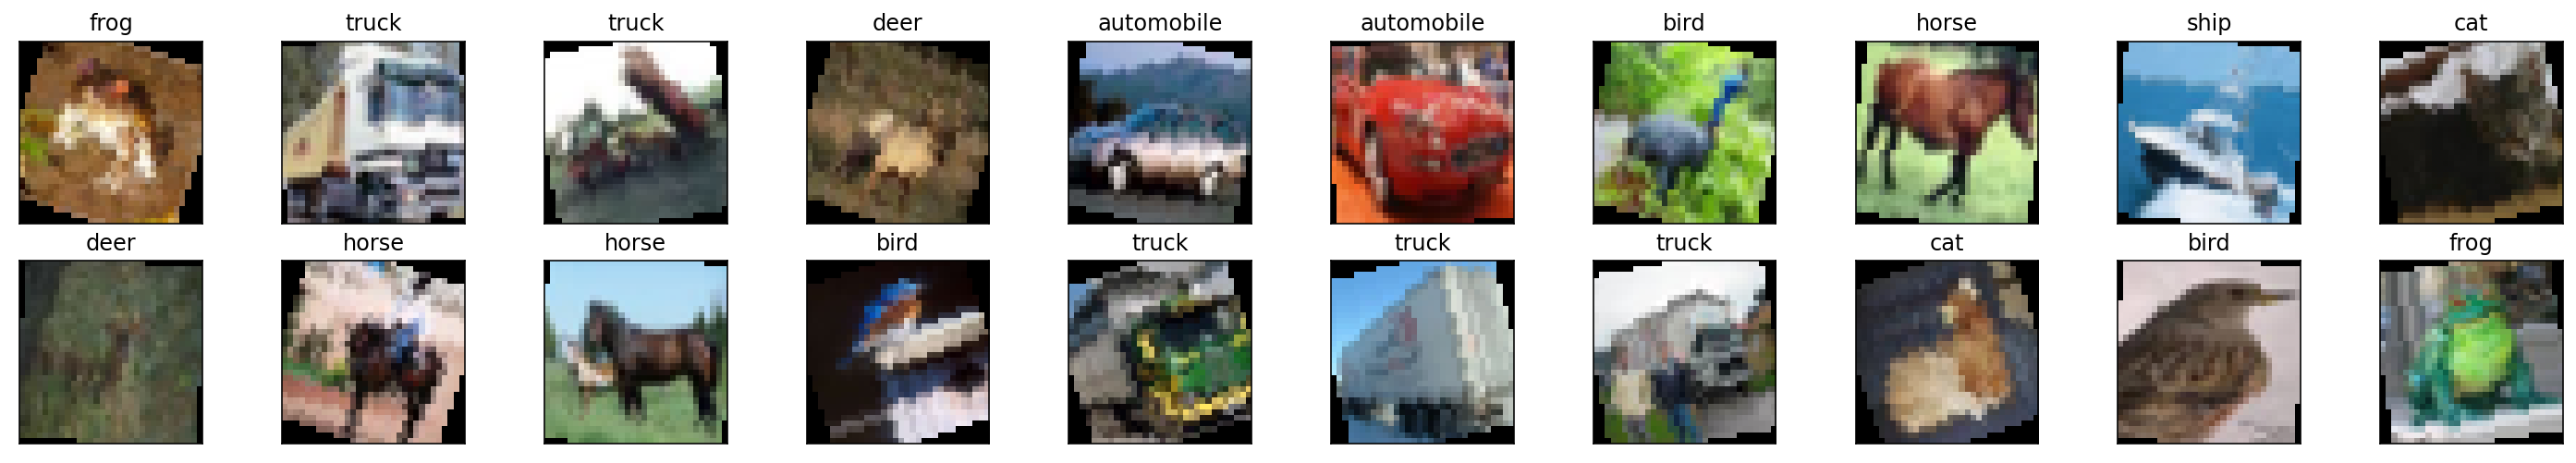

In [58]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images.numpy() # convert images to numpy for display

# plot the sample images
fig = plt.figure(figsize=(25, 4))

# display 20 sample images and classes
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

* Each image is 64x64 which is a total of 1024 pixels x 3 layers with RGB (3072), and there are 10 classes
* ReLU activations for the layers and to return the logits or log-softmax from the forward pass

In [59]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # convolution 32x32x3
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolution 16x16x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolution 8x8x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling
        self.pool = nn.MaxPool2d(2, 2)
        # linear 64 * 4 * 4 to 400
        self.fc1 = nn.Linear(64 * 4 * 4, 400)
        # linear 400 to 10
        self.fc2 = nn.Linear(400, 10)
        # dropout P = 0.25
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x
    

    

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [60]:
model = Classifier()

# move model to GPU if MPS is available
if train_on_gpu:
    model.to(torch.device("mps"))

# define the loss function
criterion = nn.CrossEntropyLoss()

# optimizer with 0.01 learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [61]:
n_epochs = 30

test_loss_min = np.Inf # set to max value
train_losses, test_losses = [], []

for epoch in range(1, n_epochs+1):
    # start with zero loss
    train_loss = 0.0
    test_loss = 0.0
    
    #train model
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.to(torch.device("mps")), target.to(torch.device("mps"))
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    # test model
    model.eval()
    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.to(torch.device("mps")), target.to(torch.device("mps"))
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
    
    # average losses
    train_loss = train_loss/len(train_loader.sampler)
    test_loss = test_loss/len(test_loader.sampler)
    
    
    # add avg losses at the end of each epoch for later to be plotted
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print('Epoch: {}, Training Loss: {:.3f}, Test Loss: {:.3f}'.format(epoch, train_loss, test_loss))
    
    # save model if validation loss decreased
    if test_loss <= test_loss_min:
        test_loss_min = test_loss
        train_loss_min = train_loss
        model_test_loss_min = model
        test_loss_min_epoch=epoch
        
        


Epoch: 1, Training Loss: 2.053, Test Loss: 1.749
Epoch: 2, Training Loss: 1.647, Test Loss: 1.491
Epoch: 3, Training Loss: 1.492, Test Loss: 1.390
Epoch: 4, Training Loss: 1.387, Test Loss: 1.298
Epoch: 5, Training Loss: 1.312, Test Loss: 1.234
Epoch: 6, Training Loss: 1.249, Test Loss: 1.161
Epoch: 7, Training Loss: 1.202, Test Loss: 1.116
Epoch: 8, Training Loss: 1.157, Test Loss: 1.098
Epoch: 9, Training Loss: 1.121, Test Loss: 1.035
Epoch: 10, Training Loss: 1.081, Test Loss: 1.010
Epoch: 11, Training Loss: 1.048, Test Loss: 1.005
Epoch: 12, Training Loss: 1.024, Test Loss: 0.950
Epoch: 13, Training Loss: 0.992, Test Loss: 0.930
Epoch: 14, Training Loss: 0.969, Test Loss: 0.911
Epoch: 15, Training Loss: 0.949, Test Loss: 0.890
Epoch: 16, Training Loss: 0.929, Test Loss: 0.860
Epoch: 17, Training Loss: 0.908, Test Loss: 0.837
Epoch: 18, Training Loss: 0.893, Test Loss: 0.852
Epoch: 19, Training Loss: 0.874, Test Loss: 0.817
Epoch: 20, Training Loss: 0.863, Test Loss: 0.828
Epoch: 21

Plot the training loss (and validation loss/accuracy, if recorded).

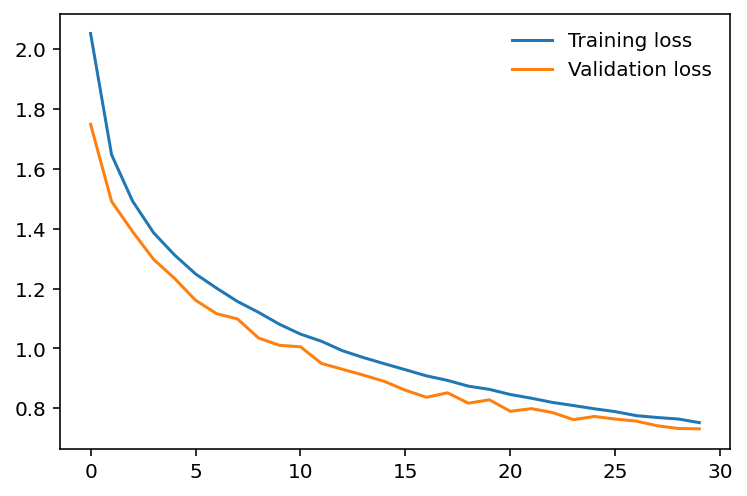

In [62]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [63]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model_test_loss_min.eval()
# make predictions over test data
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.to(torch.device("mps")), target.to(torch.device("mps"))
    output = model_test_loss_min(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.3f}\n'.format(test_loss))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.724


Test Accuracy (Overall): 74% (7470/10000)


## Saving your model
Using `torch.save`, save your model for future loading.

In [64]:
# save min valid loss model
torch.save(model_test_loss_min.state_dict(), 'checkpoint.pth')
print('Model is saved from epoch: {} \tTraining Loss: {:.6f} \tTest Loss (min): {:.6f}'.format(
        test_loss_min_epoch, train_loss_min, test_loss_min))

Model is saved from epoch: 30 	Training Loss: 0.751980 	Test Loss (min): 0.731226


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

I would recommend to build it since we achieved higher accuracy (74% > 70%) with our in-house model.